#### Columnas Originales

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.


#### Columnas Actuales

* ITEM_ID
* SHP_WEIGHT
* SHP_LENGTH
* SHP_WIDTH
* SHP_HEIGHT
* RV_PRICE, precio revisado
* STATUS
* TITLE
* LEN_ATR: cantidad de atributos
* DT_CAT_PROD: ID Catalogo del Producto-Revisado
* DT_CONDITION: Condición de Venta -Revisado
* DT_DOMAIN: Categoría de la Publicación -Revisado
* DT_SELLER: ID Vendedor -Revisado
* DT_BRAND: Marca del Producto -Revisado
* DT_MODEL: Modelo del Producto -Revisado
* SCORE: Peso ponderado del Título de la publicación sobre si excede la dimensión máxima
* EXCEDIDO: Si el producto excede el límite del correo


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn import preprocessing
import itertools

import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATASET = 'meli_dataset_c.csv'

In [3]:
#Recupero Dataset
df_raw = pd.read_csv(DATASET, low_memory=False)
df_base = df_raw.copy()

In [4]:
print(df_base.shape)
print(df_base.dtypes)
display(df_base.sample(5))

(296291, 17)
ITEM_ID          object
SHP_WEIGHT      float64
SHP_LENGTH      float64
SHP_WIDTH       float64
SHP_HEIGHT      float64
RV_PRICE        float64
STATUS           object
TITLE            object
LEN_ATR           int64
DT_CAT_PROD      object
DT_CONDITION     object
DT_DOMAIN        object
DT_SELLER        object
DT_BRAND         object
DT_MODEL         object
SCORE           float64
EXCEDIDO          int64
dtype: object


,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,RV_PRICE,STATUS,TITLE,LEN_ATR,DT_CAT_PROD,DT_CONDITION,DT_DOMAIN,DT_SELLER,DT_BRAND,DT_MODEL,SCORE,EXCEDIDO
924,G9AOOOWT1C,120.0,20.0,19.0,18.0,39.90,active,Kit Conjunto Uniforme Futebol Brasil Bebê Infa...,7,H53U1H7Q5G,new,MLB-BABY_CLOTHING_SETS,OTROS,OTROS,CONJUNTO,0.000401,0
282597,MGTELZ7X0A,6200.0,25.0,25.0,25.0,325.00,active,"10 Urso De Pelúcia + Cesta De Coração Atacado,...",10,H53U1H7Q5G,new,MLB-STUFFED_TOYS,OTROS,OTROS,OTROS,0.005663,0
175982,TMOAY5Q7B3,500.0,25.0,11.0,5.0,130.00,active,Headset Gamer 7.1 Usb P2 Kp417 Bassvibração Ad...,7,OTROS,new,MLB-HEADPHONES,OTROS,KNUP,OTROS,0.000690,0
8638,TLRG8JB3L9,100.0,25.0,11.0,5.0,94.99,active,Smartwatch Xiaomi Mi Band 2 Relógio Pulseira O...,13,OTROS,new,MLB-SPORT_WATCHES,FLE7C49TFR,XIAOMI,OTROS,0.000101,0
146446,FJDZDJOK5C,160.0,25.0,20.0,10.0,29.99,active,Conversor Audio Optico Digital Fibra/coaxial P...,8,H53U1H7Q5G,new,MLB-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS,RWJROC5ODY,OTROS,OTROS,0.000462,0


1. Definimos las columnas a utilizar para los modelos:

Descartados:
* ITEM_ID,  es la publicación y consideramos que 
* SHP_WEIGHT, no se conoce, es info del correo 
* SHP_LENGTH, idem
* SHP_WIDTH, idem
* SHP_HEIGHT, idem
* TITLE
* EXCEDIDO: creamos el atributo NO_MAQUINABLE como dato lógico

Consideramos:
* RV_PRICE
* LEN_ATR cantidad de atributos
* STATUS
* DT_CAT_PROD: ID Catalogo del Producto-Revisado
* DT_CONDITION: Condición de Venta -Revisado
* DT_DOMAIN: Categoría de la Publicación -Revisado
* DT_SELLER: ID Vendedor -Revisado
* DT_BRAND: Marca del Producto -Revisado
* DT_MODEL: Modelo del Producto -Revisado
* SCORE:
* NO_MAQUINABLE: 

In [5]:
#Pasamos la variable EXCEDIDO a lógica
df_base['NO_MAQUINABLE']=(df_base.EXCEDIDO == 1)

In [6]:
df_base[ ['NO_MAQUINABLE','EXCEDIDO'] ].sample(5)

,NO_MAQUINABLE,EXCEDIDO
122846,False,0
51936,False,0
258365,False,0
287555,False,0
131022,False,0


In [7]:
col_categorias=['STATUS','DT_CAT_PROD','DT_CONDITION','DT_DOMAIN','DT_SELLER','DT_BRAND','DT_MODEL']
col_continuas=['RV_PRICE','LEN_ATR','SCORE']
col_x = col_continuas + col_categorias 
col_y = ['NO_MAQUINABLE']

In [8]:
df_modelo=df_base[col_x + col_y]

In [9]:
print(df_modelo.shape)
print(df_modelo.dtypes)

(296291, 11)
RV_PRICE         float64
LEN_ATR            int64
SCORE            float64
STATUS            object
DT_CAT_PROD       object
DT_CONDITION      object
DT_DOMAIN         object
DT_SELLER         object
DT_BRAND          object
DT_MODEL          object
NO_MAQUINABLE       bool
dtype: object


2. Armamos conjuntos de entreamiento y validación

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

In [11]:
sMM=MinMaxScaler()
Xcon = sMM.fit_transform(df_modelo[col_continuas])
Xcon = pd.DataFrame(Xcon, columns=col_continuas)

print(Xcon.shape)
display(df_modelo[col_continuas].head(5))
display(Xcon.head(5))
display(Xcon.describe())

(296291, 3)


,RV_PRICE,LEN_ATR,SCORE
0,68.0,6,0.000326
1,145.9,9,0.004556
2,145.9,9,0.004556
3,145.9,9,0.004556
4,145.9,9,0.000224


,RV_PRICE,LEN_ATR,SCORE
0,0.002263,0.10,0.000312
1,0.004860,0.15,0.004543
2,0.004860,0.15,0.004543
3,0.004860,0.15,0.004543
4,0.004860,0.15,0.000210


,RV_PRICE,LEN_ATR,SCORE
count,296291.000000,296291.000000,296291.000000
mean,0.005810,0.131977,0.122354
std,0.014117,0.094612,0.261138
min,0.000000,0.000000,0.000000
25%,0.001677,0.066667,0.000267
50%,0.003437,0.133333,0.002072
75%,0.005930,0.183333,0.055521
max,1.000000,1.000000,1.000000


In [12]:
Xcat = pd.get_dummies(df_modelo[col_categorias],columns=col_categorias, sparse=True)

#Junto Categóricas y Numéricas
X=pd.concat([Xcat, Xcon], axis=1)
y=df_modelo[col_y]

print(X.shape)
print(X.dtypes)

display(X.head(5))
display(y.head(5))

(296291, 4384)
STATUS_active          Sparse[uint8, 0]
STATUS_closed          Sparse[uint8, 0]
STATUS_inactive        Sparse[uint8, 0]
STATUS_paused          Sparse[uint8, 0]
STATUS_under_review    Sparse[uint8, 0]
                             ...       
DT_MODEL_X_PLAY        Sparse[uint8, 0]
DT_MODEL__             Sparse[uint8, 0]
RV_PRICE                        float64
LEN_ATR                         float64
SCORE                           float64
Length: 4384, dtype: object


,STATUS_active,STATUS_closed,STATUS_inactive,STATUS_paused,STATUS_under_review,DT_CAT_PROD_B2BWER04UG,DT_CAT_PROD_B5O1R5Z1VR,DT_CAT_PROD_BF6NGKUMZ9,DT_CAT_PROD_BW4AU3M2JW,DT_CAT_PROD_CCDEBX4JCH,...,DT_MODEL_XBOX_ONE,DT_MODEL_XBOX_ONE_S,DT_MODEL_XENON,DT_MODEL_XIAOMI,DT_MODEL_XTREME,DT_MODEL_X_PLAY,DT_MODEL__,RV_PRICE,LEN_ATR,SCORE
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.002263,0.10,0.000312
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.004860,0.15,0.004543
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.004860,0.15,0.004543
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.004860,0.15,0.004543
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.004860,0.15,0.000210


,NO_MAQUINABLE
0,False
1,False
2,False
3,False
4,False


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [14]:
#Separamos en train(80%) y test (20%) y entrenamos el modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
print('TRAIN')
print('X:', X_train.shape)
print('y:', y_train.shape)

print('TEST')
print('X:', X_test.shape)
print('y:', y_test.shape)

TRAIN
X: (237032, 4384)
y: (237032, 1)
TEST
X: (59259, 4384)
y: (59259, 1)


3. Probamos SGDClassifier con parámetros por defecto

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
modeloSDG = SGDClassifier(random_state=5)
modeloSDG.fit(X_train, y_train)

C:\Users\Marcelo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=5, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
y_train_pred = modeloSDG.predict(X_train)
y_test_pred  = modeloSDG.predict(X_test)

In [19]:
print('Exactitud para TRAIN: %.4f' % accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Exactitud para TEST : %.4f' % accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Exactitud para TRAIN: 0.9773
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    226390
        True       0.73      0.78      0.76     10642

    accuracy                           0.98    237032
   macro avg       0.86      0.88      0.87    237032
weighted avg       0.98      0.98      0.98    237032

Exactitud para TEST : 0.9765
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     56590
        True       0.73      0.76      0.75      2669

    accuracy                           0.98     59259
   macro avg       0.86      0.88      0.87     59259
weighted avg       0.98      0.98      0.98     59259



In [20]:
from ml.visualization import plot_confusion_matrix

In [21]:
confusion_matrix(y_train, y_train_pred)

array([[223357,   3033],
       [  2337,   8305]], dtype=int64)

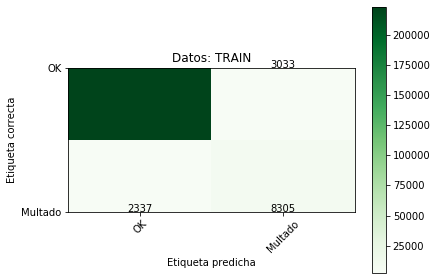

In [22]:
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), classes=['OK','Multado'], title="Datos: TRAIN", cmap=plt.cm.Greens)

In [23]:
confusion_matrix(y_test, y_test_pred)

array([[55825,   765],
       [  628,  2041]], dtype=int64)

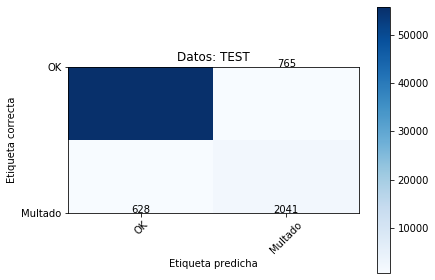

In [24]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=['OK','Multado'], title="Datos: TEST")

4. Probamos RandomFores con parámetros por defecto

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
modeloRFC = RandomForestClassifier(random_state=5)
modeloRFC.fit(X_train, y_train)

C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [27]:
y_train_pred = modeloRFC.predict(X_train)
y_test_pred  = modeloRFC.predict(X_test)

In [28]:
print('Exactitud para TRAIN: %.4f' % accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Exactitud para TEST : %.4f' % accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Exactitud para TRAIN: 0.9952
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    226390
        True       0.97      0.92      0.94     10642

    accuracy                           1.00    237032
   macro avg       0.98      0.96      0.97    237032
weighted avg       1.00      1.00      1.00    237032

Exactitud para TEST : 0.9768
              precision    recall  f1-score   support

       False       0.98      0.99      0.99     56590
        True       0.78      0.67      0.72      2669

    accuracy                           0.98     59259
   macro avg       0.88      0.83      0.86     59259
weighted avg       0.98      0.98      0.98     59259



In [29]:
confusion_matrix(y_train, y_train_pred)

array([[226042,    348],
       [   801,   9841]], dtype=int64)

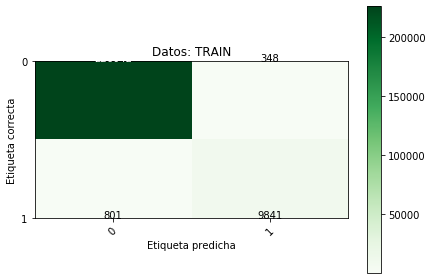

In [30]:
plot_confusion_matrix(confusion_matrix(y_train, y_train_pred), classes=[0,1], title="Datos: TRAIN", cmap=plt.cm.Greens)

In [31]:
confusion_matrix(y_test, y_test_pred)

array([[56098,   492],
       [  882,  1787]], dtype=int64)

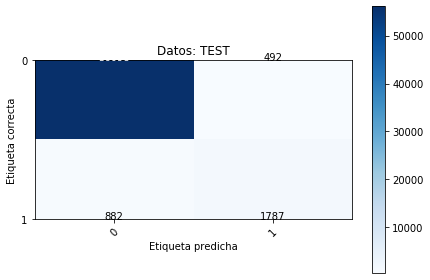

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, y_test_pred), classes=[0,1], title="Datos: TEST")

In [41]:
modeloRFC.feature_importances_.shape

(4384,)

In [ ]:
#Verificamos los principales atributos considerados por el algoritmo

In [52]:
atr_imp=pd.DataFrame(data=zip(X.columns, modeloRFC.feature_importances_), columns=['Atributo','Importancia'] )
atr_imp.sort_values(by='Importancia', ascending=False, inplace=True)
atr_imp.head(10)

,Atributo,Importancia
4383,SCORE,0.498368
4381,RV_PRICE,0.092246
4382,LEN_ATR,0.039542
0,STATUS_active,0.006678
141,DT_DOMAIN_MLB-AUTOMOTIVE_DEFLECTORS,0.006670
2117,DT_SELLER_OTROS,0.006665
3512,DT_BRAND_OTROS,0.005879
3,STATUS_paused,0.005402
4201,DT_MODEL_OTROS,0.004923
967,DT_DOMAIN_MLB-ROOF_RACKS,0.004916
